In [10]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob
from matplotlib.ticker import MultipleLocator
import subprocess
from scipy.optimize import curve_fit
from scipy.stats import chi2
plt.rcParams["xtick.top"] = True    # enable top x-ticks
plt.rcParams["ytick.right"] = True  # enable right y-ticks
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [11]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))
frac = 0.9542011788469517 # (Na21/(p+Na21)) amount of energy the daughter nucleus gets of the total energy released in the decay
frac_err = 1.032071836027589e-10 # uncertainty of the fraction
mp  = 1007825.031898
mNa = 20997654.459
mNe = 19992440.17525
S1p = 5504.1000
S2p = 7935.9963
QB  = 17600

def y1(x, E1):
    return E1 + 0*x
def y2(x, E1, E2): # E1 may be fixed
    M = mp/mNa
    return E2 - 2*M*np.sqrt(E1*E2)*x + E1*M**2

In [12]:
EE2p = np.array([])
E1 = np.array([])
E2 = np.array([])
Q2p = np.array([])
theta = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E", "E1", "E2", "Q2p", "Theta"],
                            cut="Q2p>0"):
    EE2p=np.append(EE2p, ak.flatten(batch.E))
    E1=np.append(E1, batch.E1)
    E2=np.append(E2, batch.E2)
    Q2p=np.append(Q2p, batch.Q2p)
    theta=np.append(theta, batch.Theta)

import re

E_excited = []
E_excited_err = []

pattern = re.compile(r"21NA\s+L\s+([\d.]+)\s+([\d.]+)")

with open("Na21_ensdf.txt", "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            E_excited.append(float(match.group(1)))
            E_excited_err.append(float(match.group(2)))

E_excited = np.array(E_excited)
E_excited_err = np.array(E_excited_err)

Erik_Es = np.array([3.52,3.86,4.29,4.46,5.02,5.15,5.37,5.95,6.20,6.47,7.49,8.13,8.31,8.42,8.55,8.8,8.97,9.0,9.8,10.2,10.7])*1e3
Erik_Es_err = np.array([2,1,2,2,1,2,1,2,1,2,2,2,2,2,0,0,1,0,1,0,2])



5811 -> ENSDF: [5815. 5828.]


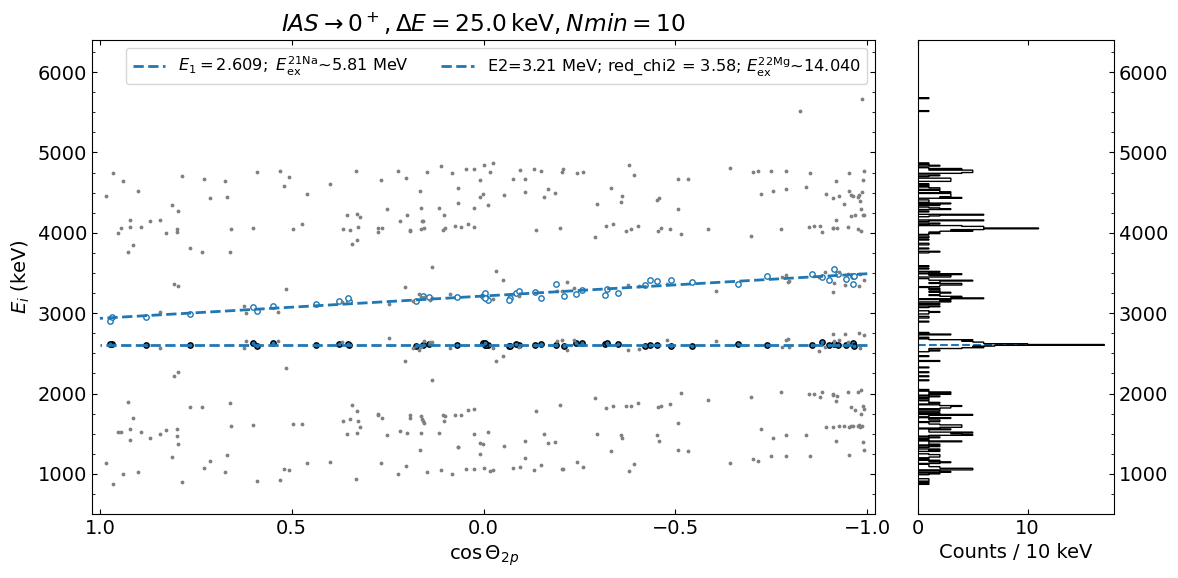

4297 -> ENSDF: [4294.3]
4297 -> Erik: [4290.]


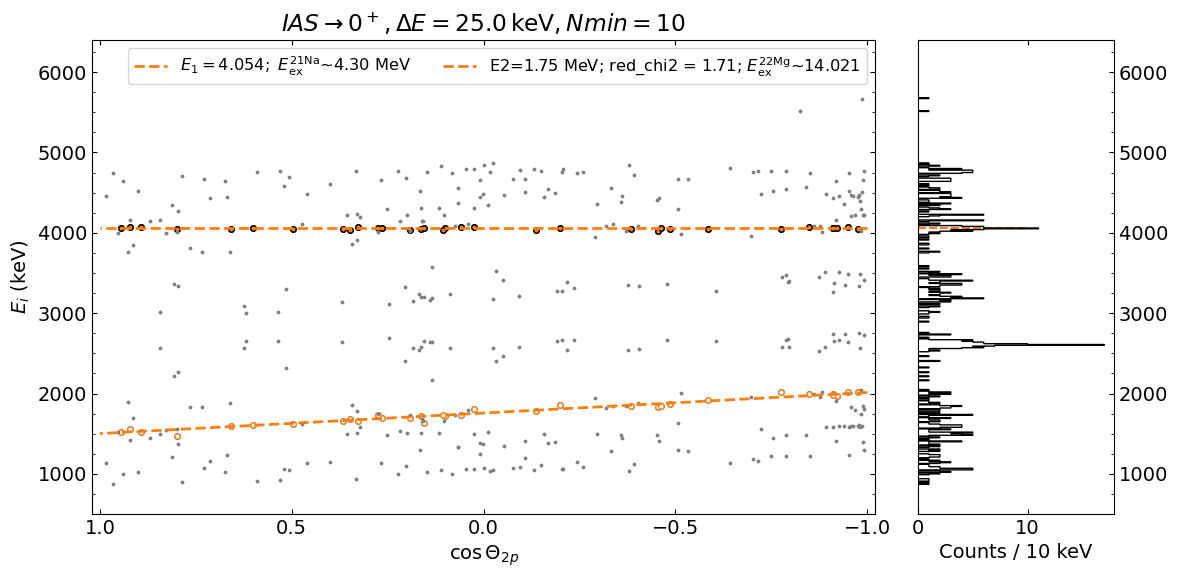

3550 -> ENSDF: [3544.3]
3550 -> Erik: [3520.]


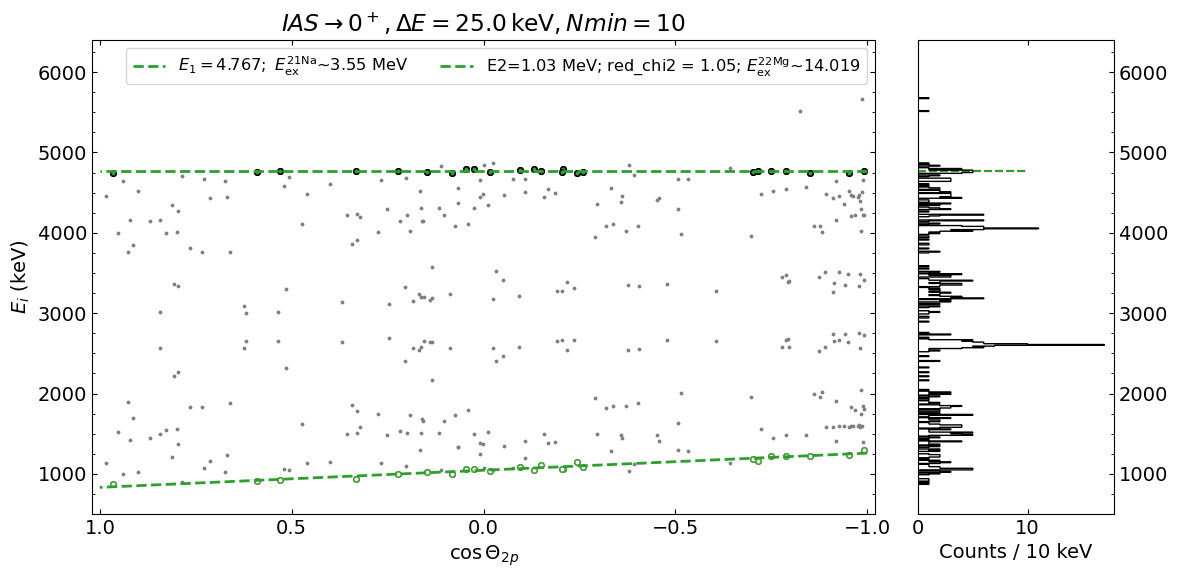

5762 -> ENSDF: [5770.]


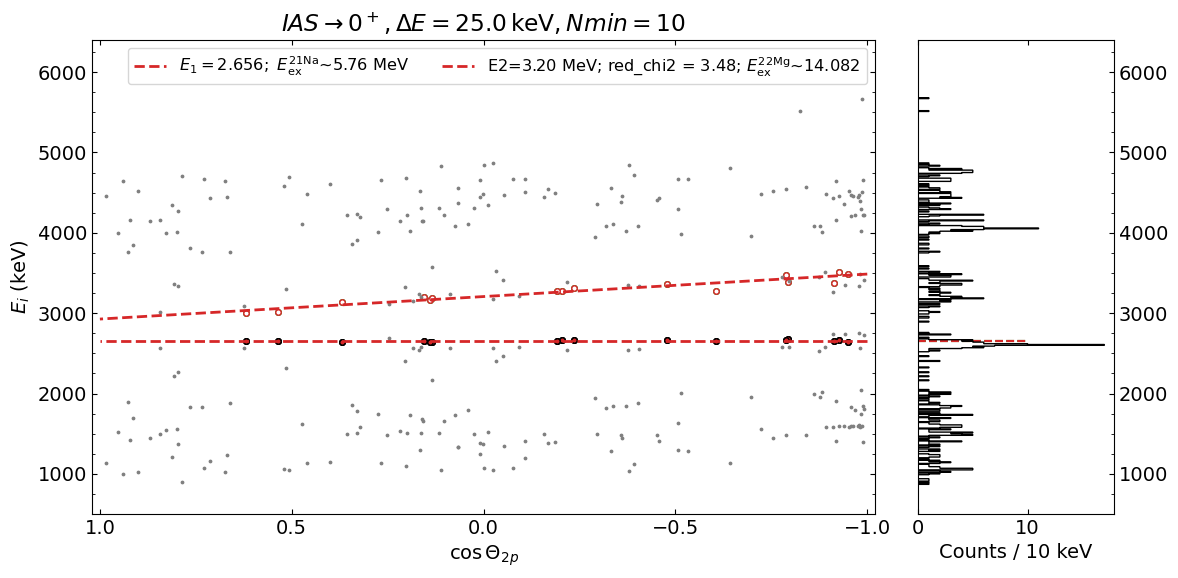

6975 -> ENSDF: [6992.]


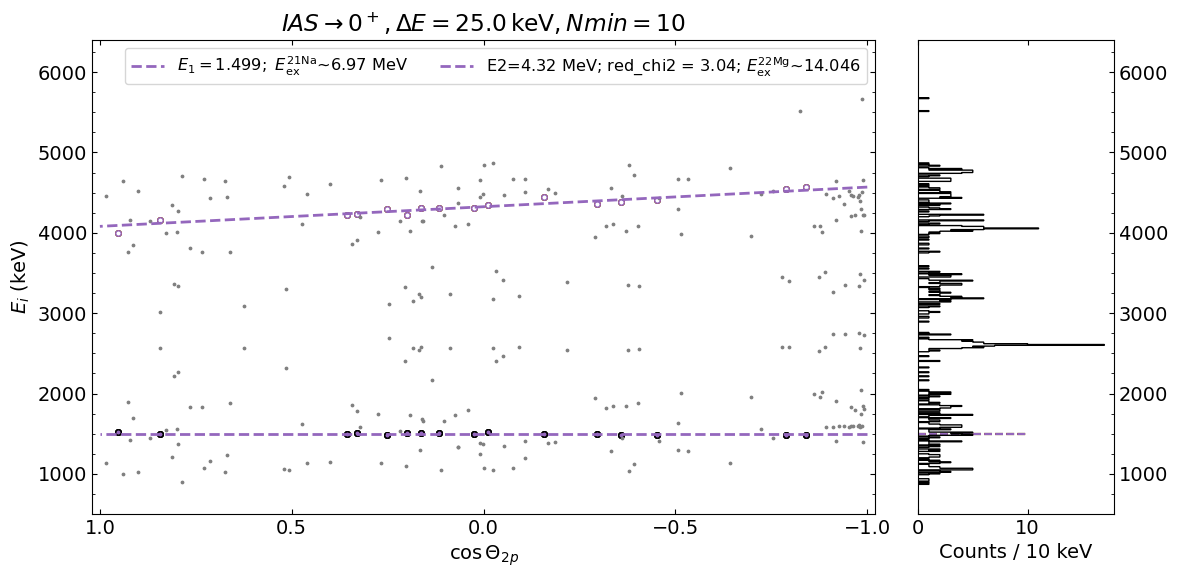

5858 -> ENSDF: [5828. 5884.]


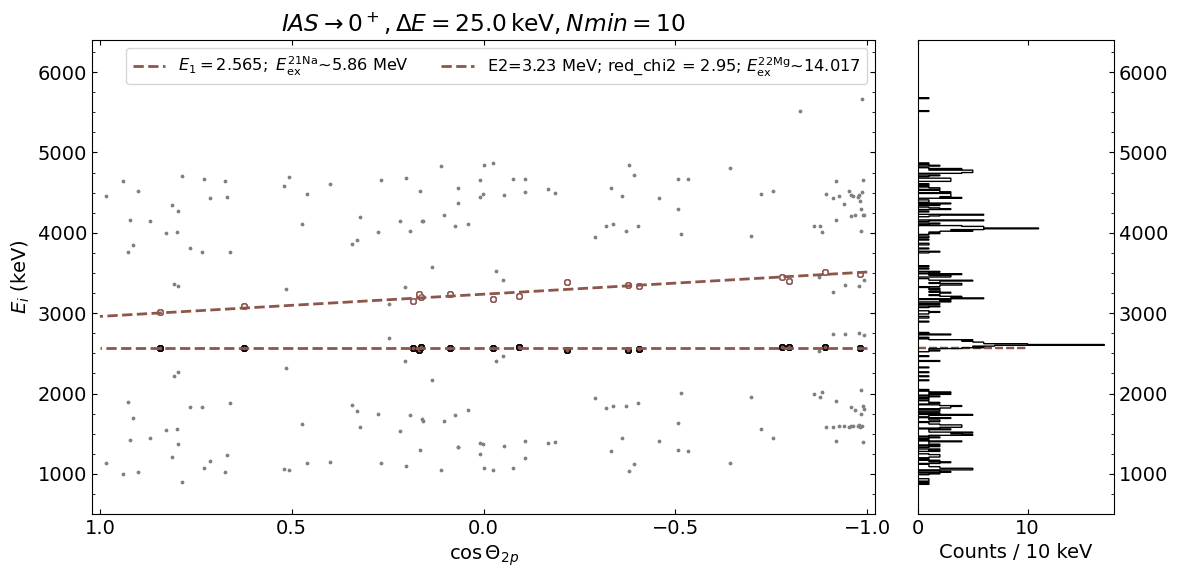

3870 -> ENSDF: [3862.2]
3870 -> Erik: [3860.]


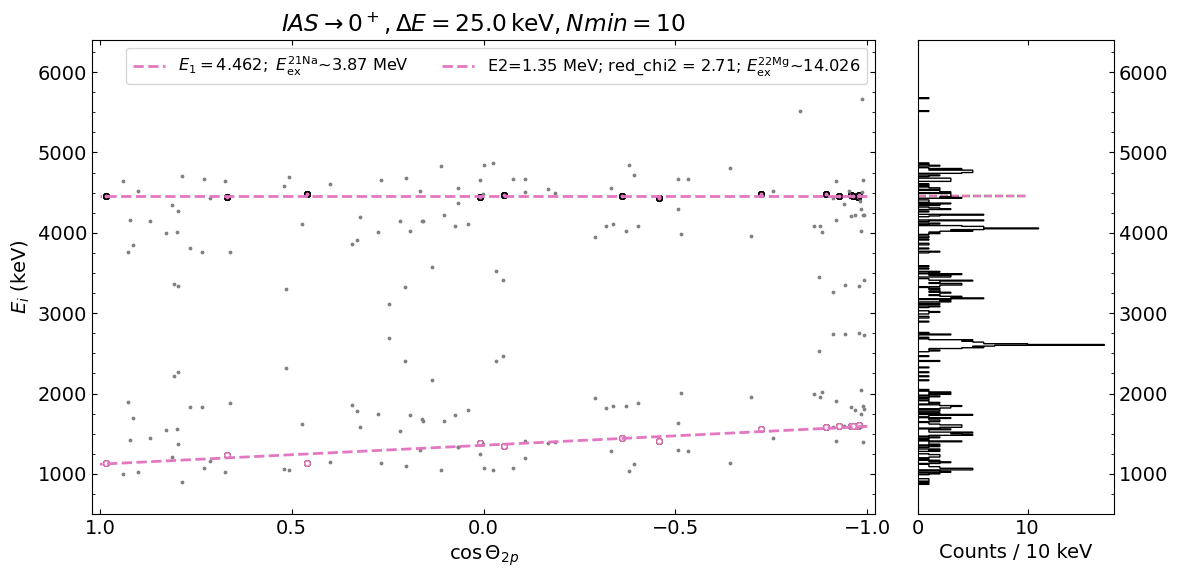

3662 -> ENSDF: [3678.9]


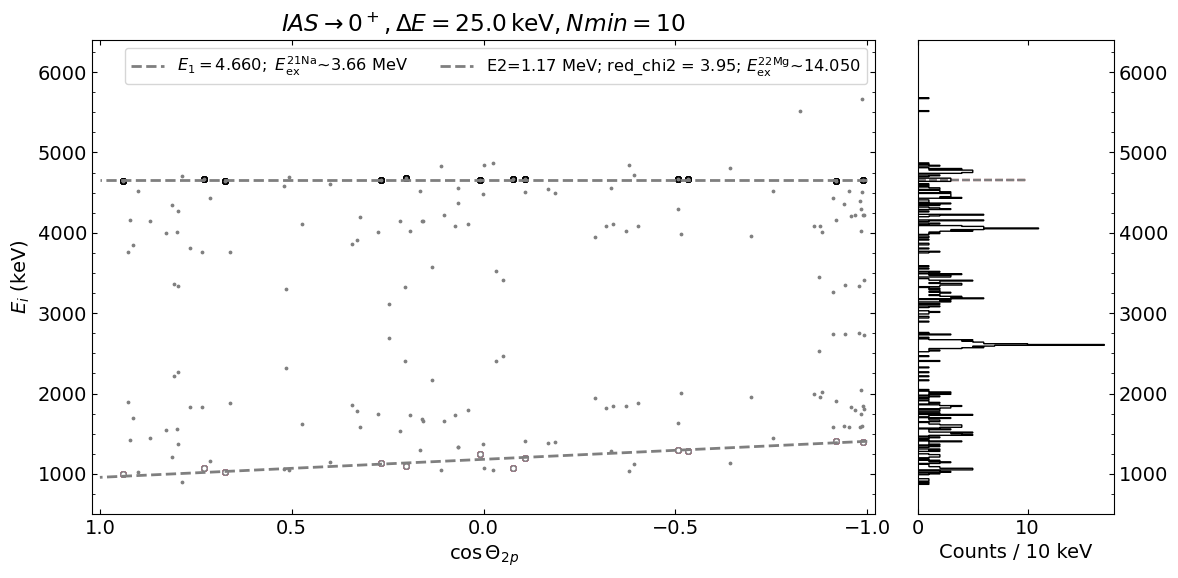

The reduced chi2 values from the fits
[3.576 1.71  1.052 3.483 3.037 2.954 2.712 3.949]

Peaks identified by previous studies of 21Na(found values)
[5811. 4297. 3550. 5762. 6975. 5858. 3870. 3662.]

Peaks found in Ensdf / Erik ?
[(True, False), (True, True), (True, True), (True, False), (True, False), (True, False), (True, True), (True, False)]

Peaks not found to match any previously found levels in 21Na
[]

E1 energies:
[2609. 4054. 4767. 2656. 1499. 2565. 4462. 4660.]
E2 energies:
[3207. 1748. 1035. 3201. 4321. 3230. 1346. 1171.]
Excited state energies of 21Na:
[5811. 4297. 3550. 5762. 6975. 5858. 3870. 3662.]


In [13]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 25.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands0, e2bands0, cos1bands0, cos2bands0 = [], [], [], []
Ex, E1s,E2s = [], [], []
assigned_counts0 = [] ## following order of Ex

# ---- Q2p gate ----
m   = 6400
lim = (6000, 6230)
title = fr"$IAS \rightarrow 0^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
total_counts = len(e1)
N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = 14050  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts0.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        assigned_counts0.append(0)

    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands0.append(E1_band)
    e2bands0.append(E2_band)
    cos1bands0.append(cos1_band)
    cos2bands0.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,10,color, ls='--')
        unused_cos0 = cos_th[event_band_idx == -1]
        unused_e10 = e1[event_band_idx == -1]
        unused_e20 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)

    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit)/1e3:.3f}")

    Ex.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)

    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(500,m)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    # ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))


Found 21Na levels from IAS->0+:  [3549.8351233  3662.08143678 3869.84363923 4296.80305586 5761.93507255
 5811.42505401 5857.87621139 6974.92440897]
Percentage of used events:  68.58 %
82 179 261


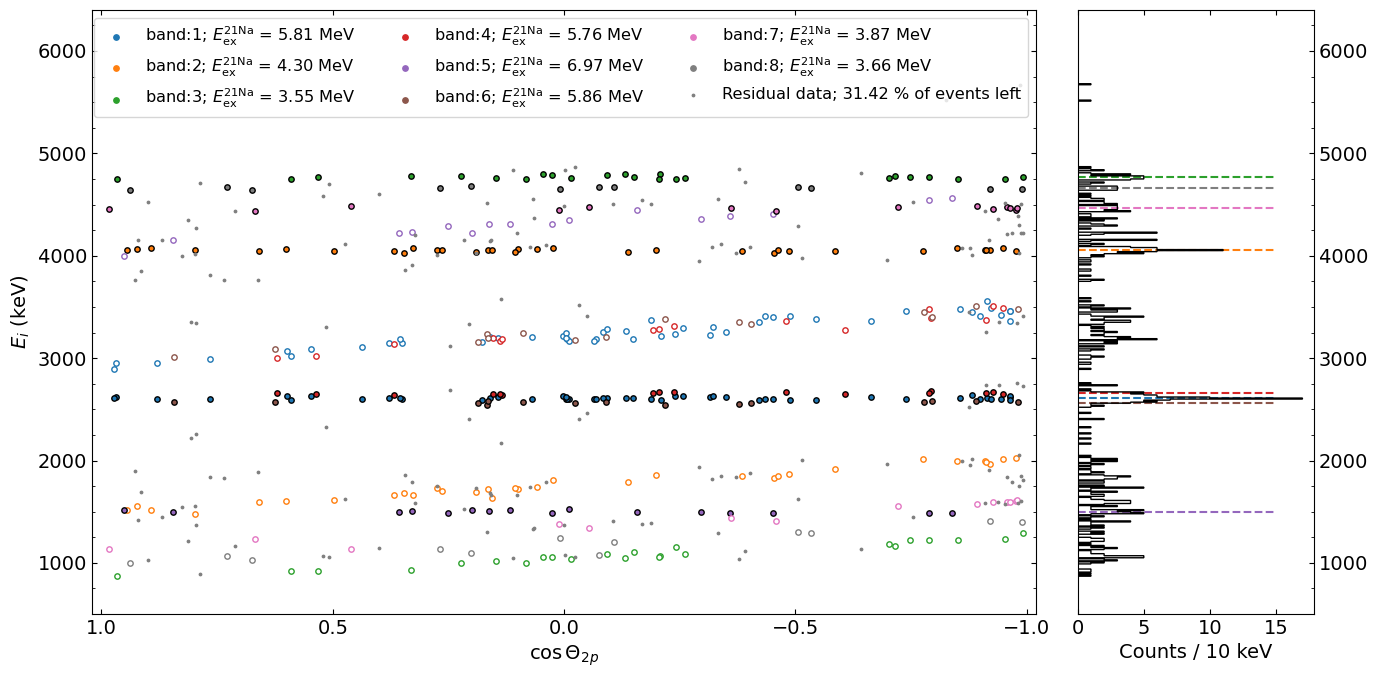


KS statistic = 0.1001, p-value = 0.4798


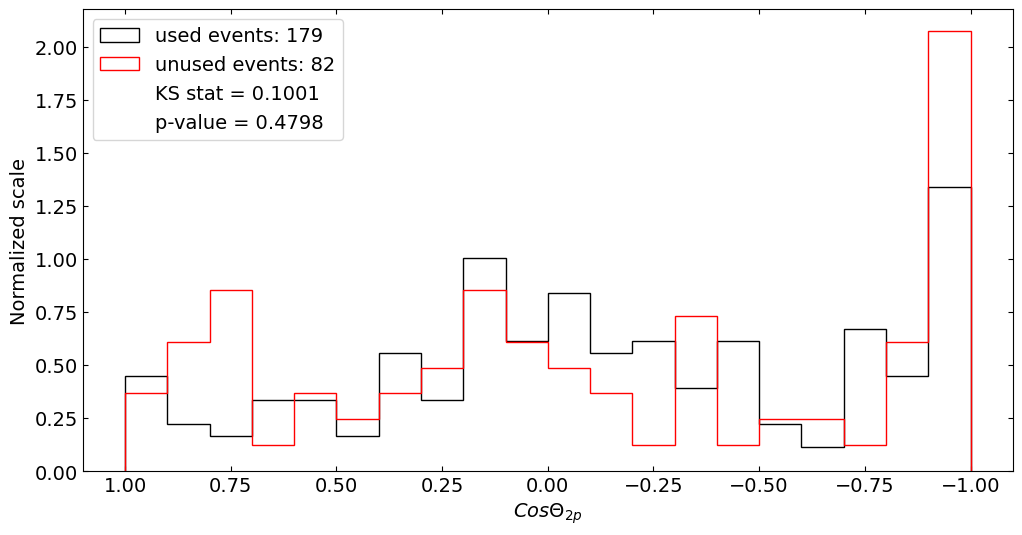

In [14]:
print("Found 21Na levels from IAS->0+: ",np.sort(Ex))
print("Percentage of used events: ", np.round(np.sum(assigned_counts0)/total_counts*100,2), "%")
print(len(unused_cos0), np.sum(assigned_counts0),total_counts)
plt.rcParams.update({'font.size': 14})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), sharey=True, gridspec_kw={'width_ratios':[4,1]})

colors = plt.cm.tab10.colors

for b_idx, (cos1, e1b, cos2, e2b,ex) in enumerate(zip(cos1bands0, e1bands0, cos2bands0, e2bands0,Ex)):
    color = colors[b_idx % len(colors)]
    ax1.scatter(cos1, e1b, s=15, facecolors=color, edgecolors='k')
    ax1.scatter(cos2, e2b, s=15, facecolors='white', edgecolors=color)
    ax1.scatter(-1000,-1000, s=15, facecolors=color, label=rf"band:{b_idx+1}; $E_{{\mathrm{{ex}}}}^{{21\mathrm{{Na}}}}$ = {ex/1e3:.2f} MeV")
    ax2.hlines(np.mean(e1b), 0, 15, color=color, ls='--')

ax1.scatter(unused_cos0, unused_e10, color='gray', s=3, label=f"Residual data; {100-np.round(np.sum(assigned_counts0)/total_counts*100, 2)} % of events left")
ax1.scatter(unused_cos0, unused_e20, color='gray', s=3)
ax1.set_xlabel(r"$\cos\Theta_{2p}$")
ax1.set_ylabel(r"$E_i$ (keV)")
ax1.set_yticks(np.arange(0, 6400, 250), minor=True, fontsize=14)
ax1.set_xticks(np.arange(1,-1.5,-0.5), fontsize=14)
ax1.set_xlim(1.02,-1.02)
ax1.legend(ncol=3, fontsize='small')

mask = (Q2p>6000) & (Q2p<6230)
bins = np.arange(0, 7000+10, 10)
h1, _ = np.histogram(E1[mask], bins=bins)
h2, _ = np.histogram(E2[mask], bins=bins)
ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step', orientation='horizontal', color='k')
ax2.set_xlabel('Counts / 10 keV', fontsize=14)
ax2.yaxis.set_ticks_position('right')
ax2.set_yticks(np.arange(0, 6400, 250), minor=True, fontsize=14)
ax1.set_ylim(500, 6400)

fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
plt.tight_layout()
plt.savefig("all2p0.pdf")
plt.show()
print()

from scipy.stats import ks_2samp


plt.figure(figsize=(12,6))
bi = np.arange(-1,1+0.1,0.1)
h4, _ = np.histogram(unused_cos0, bins=bi)
w1 = 0
w2 = 0
for c1,c2 in zip(cos1bands0,cos2bands0):
    h5, _ = np.histogram(c1, bins=bi)
    h6, _ = np.histogram(c2, bins=bi)
    w1+=h5
    w2+=h6
plt.hist(bi[:-1], bins=bi, weights=w1+w2, histtype='step', color='k', density=True, label=f"used events: {np.sum(assigned_counts0)}")
plt.hist(bi[:-1], bins=bi, weights=h4, histtype='step', color='r', density=True, label=f"unused events: {total_counts-np.sum(assigned_counts0)}")
plt.xticks(np.arange(1.5,-1.5,-0.25))
plt.xlim(1.1,-1.1)
plt.legend(loc='upper left')
plt.xlabel(r"$Cos\Theta _{2p}$")
plt.ylabel("Normalized scale")

unused = np.array(unused_cos0)
used = np.concatenate(cos1bands0 + cos2bands0)

ksstatistic, pvalue = ks_2samp(used, unused)

print(f"KS statistic = {ksstatistic:.4f}, p-value = {pvalue:.4g}")
plt.plot([], [], ' ', label=f"KS stat = {ksstatistic:.4f}")
plt.plot([], [], ' ', label=f"p-value = {pvalue:.4g}")


plt.legend(loc='upper left', fontsize=14)


No suitable exctited level was found for 6606


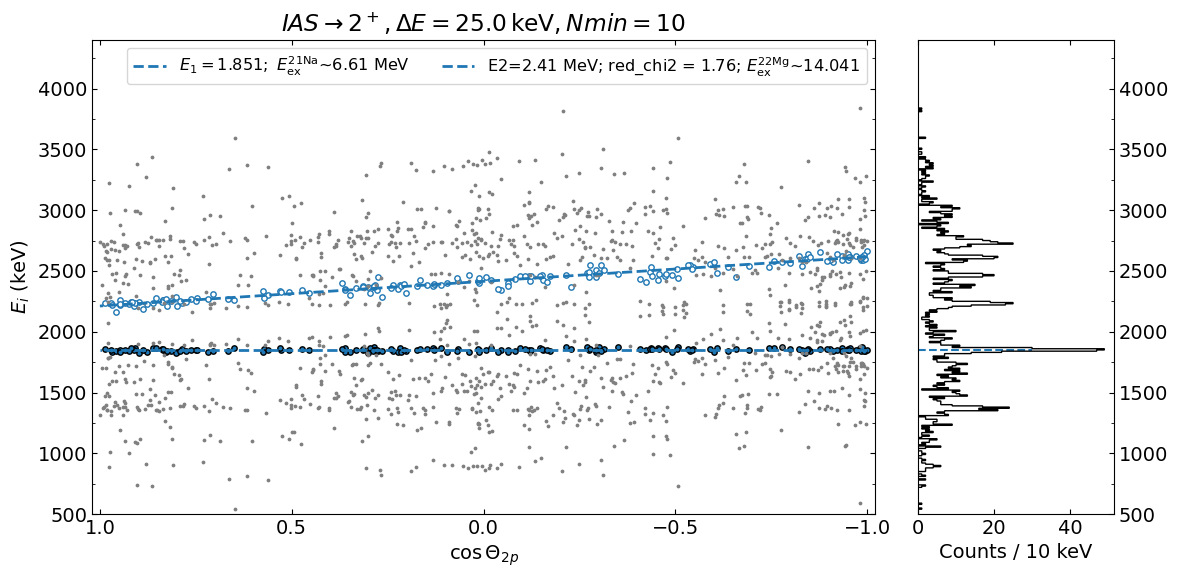

No suitable exctited level was found for 5683


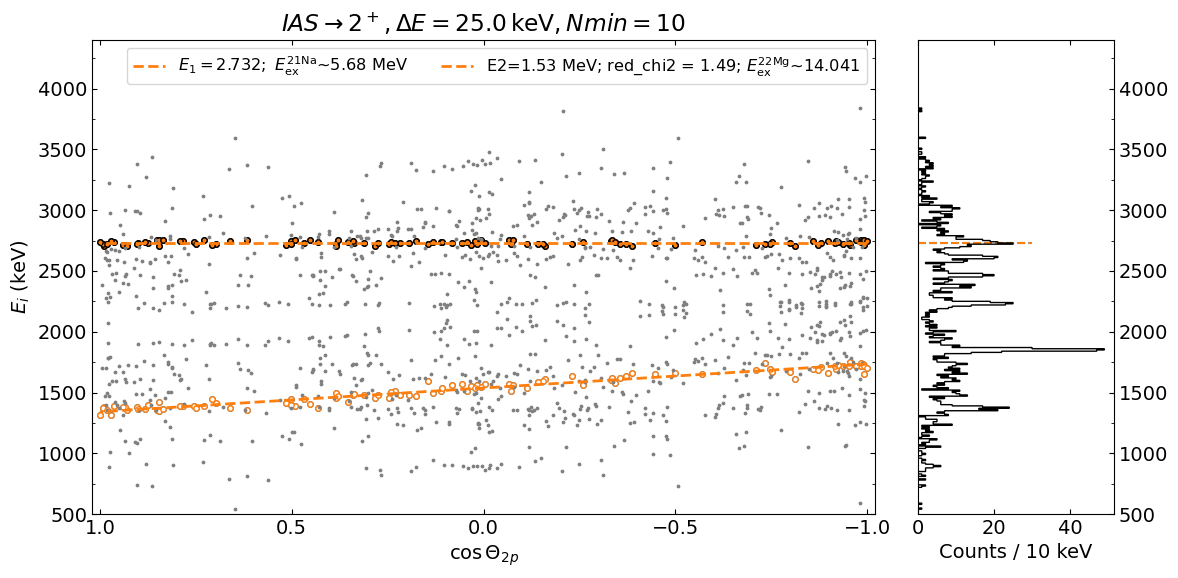

6212 -> Erik: [6200.]


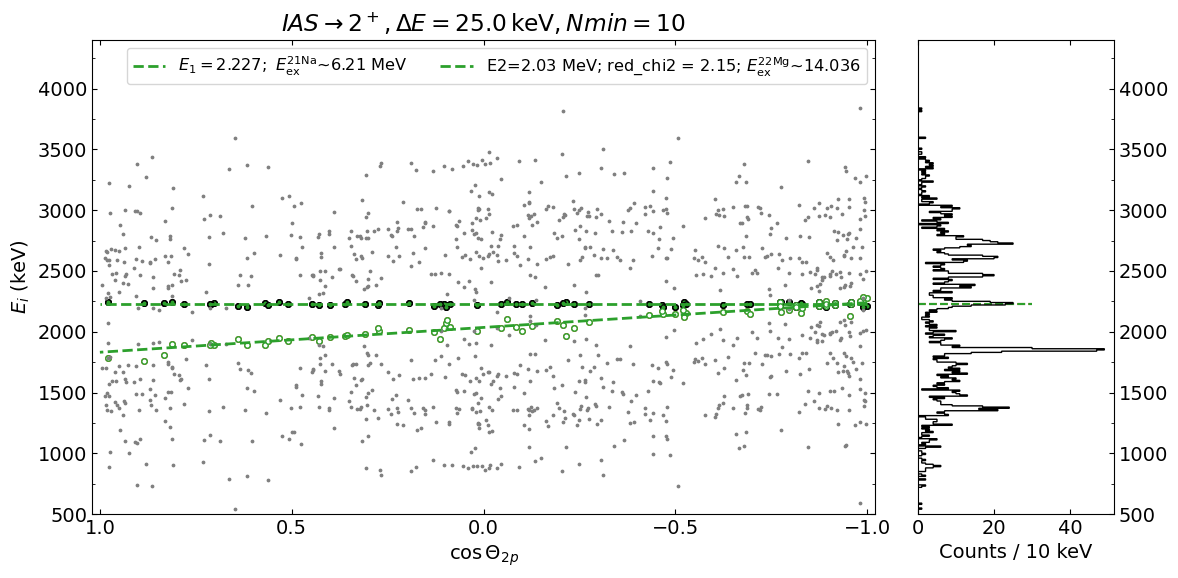

No suitable exctited level was found for 7108


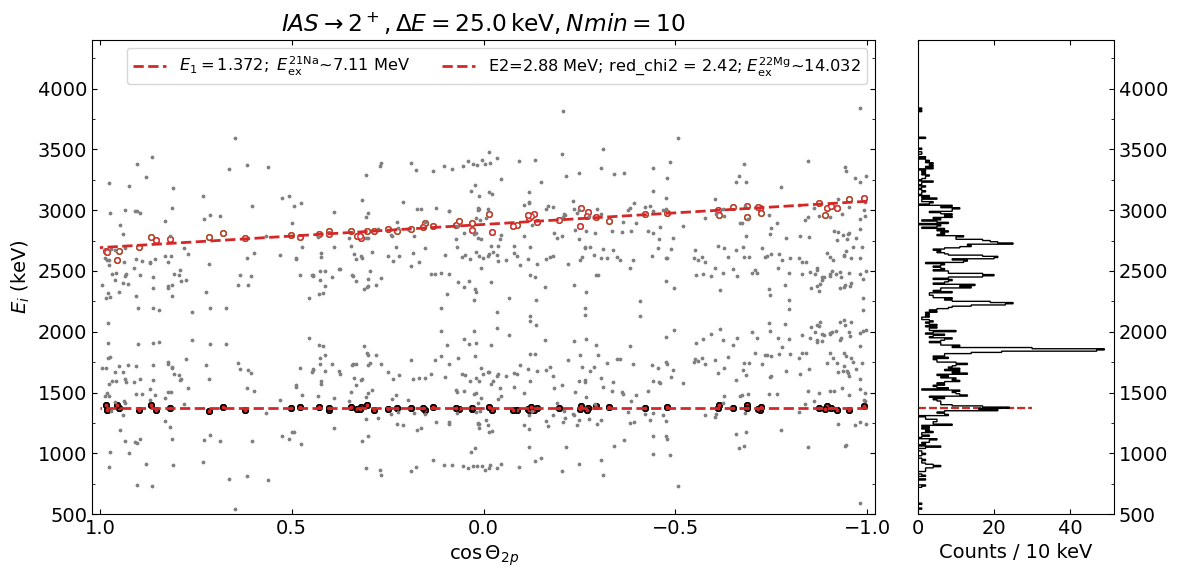

5809 -> ENSDF: [5815. 5828.]


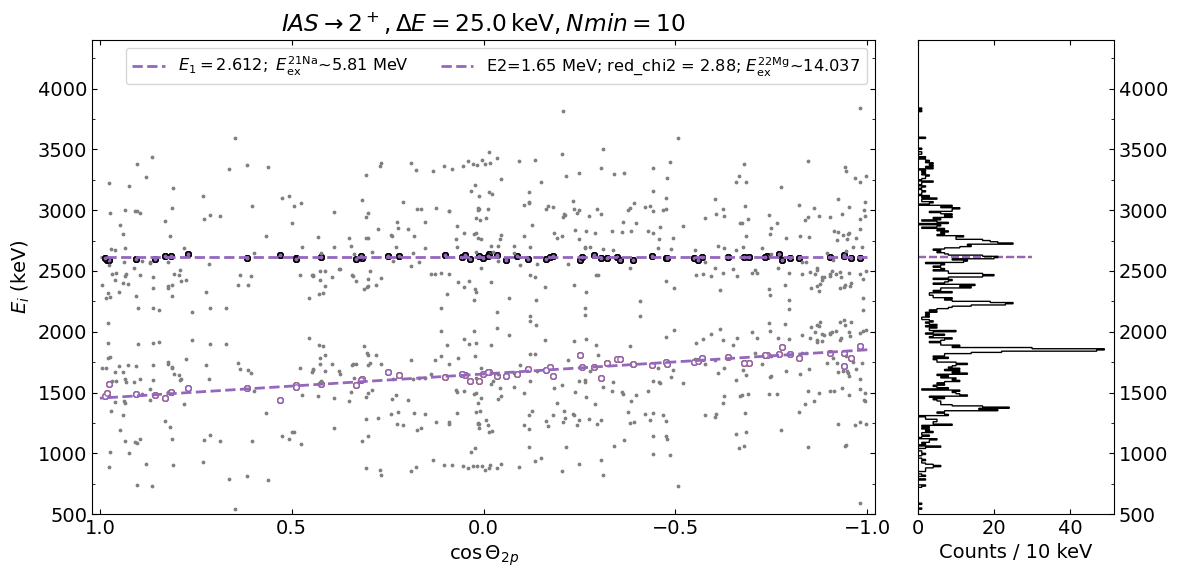

5957 -> ENSDF: [5979.]
5957 -> Erik: [5950.]


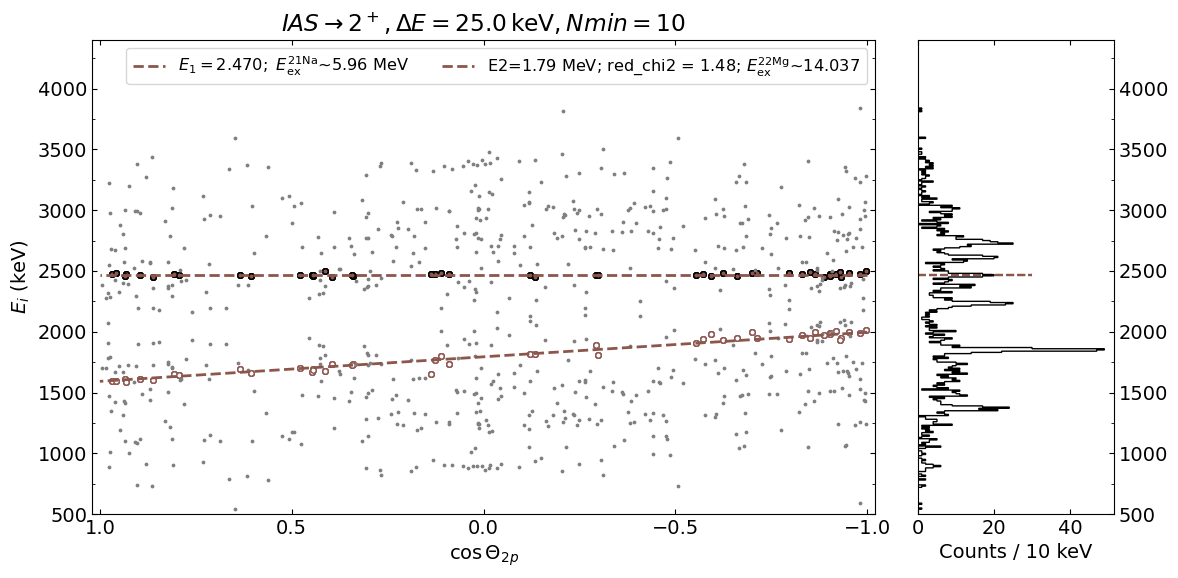

5388 -> ENSDF: [5380.]
5388 -> Erik: [5370.]


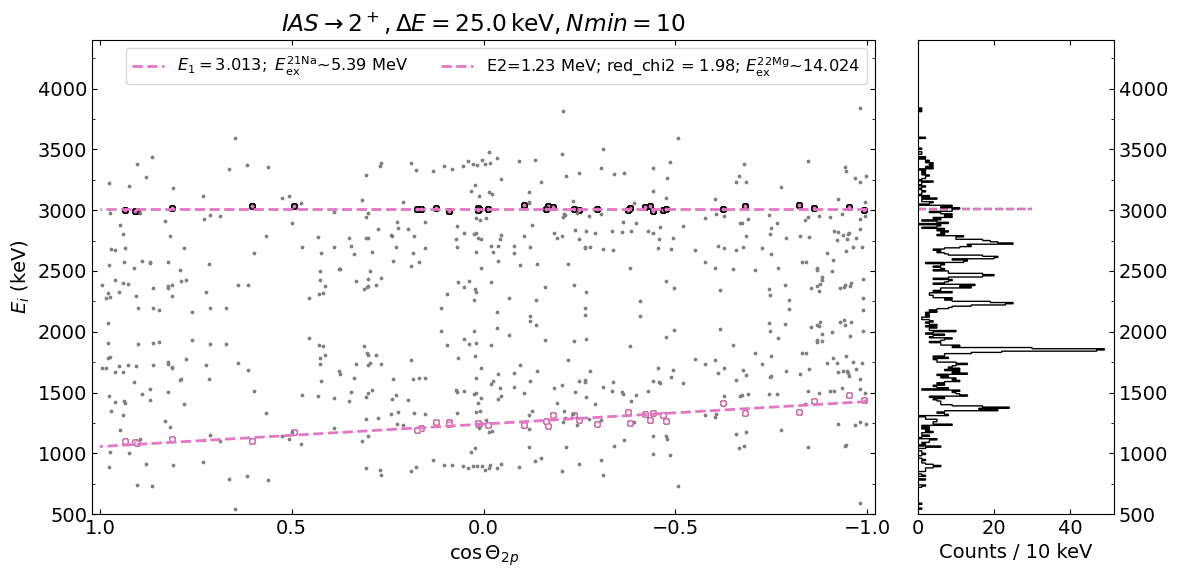

6978 -> ENSDF: [6992.]


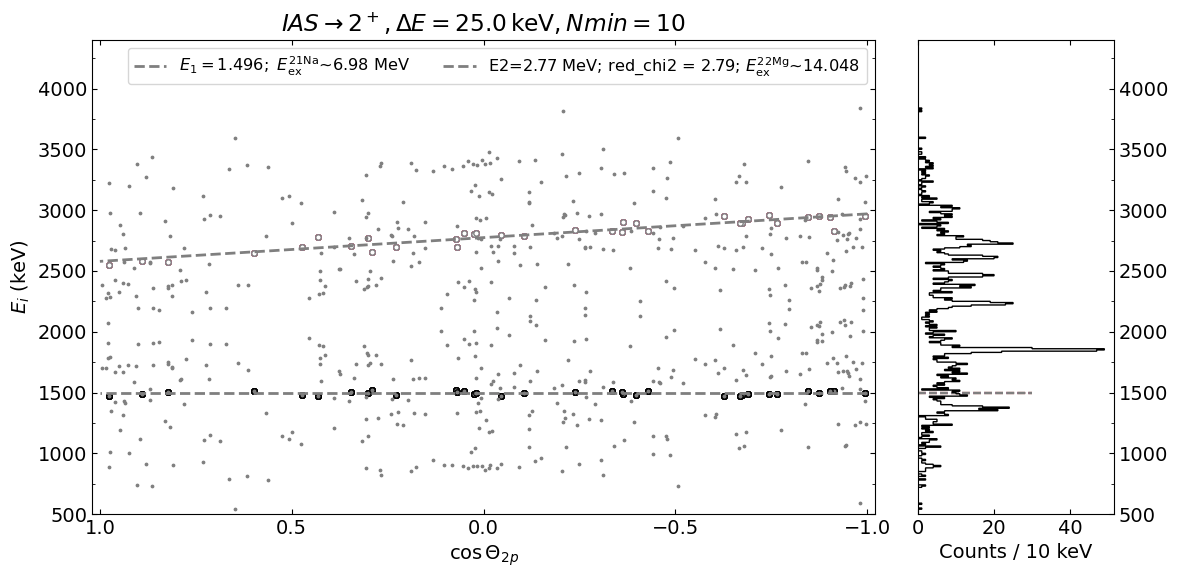

6060 -> ENSDF: [6070.]


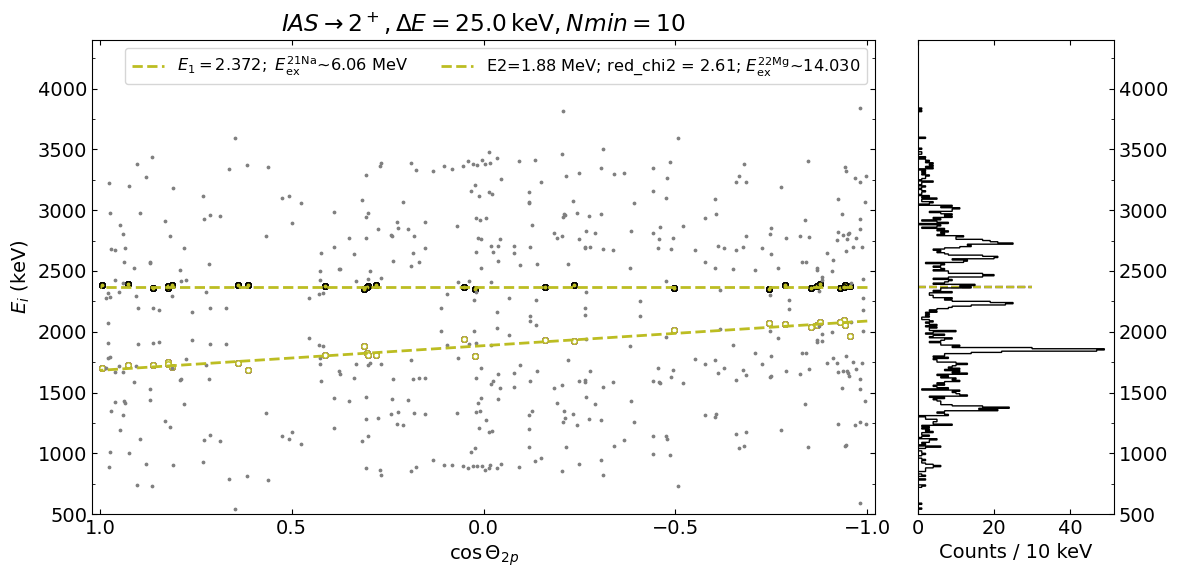

No suitable exctited level was found for 5729


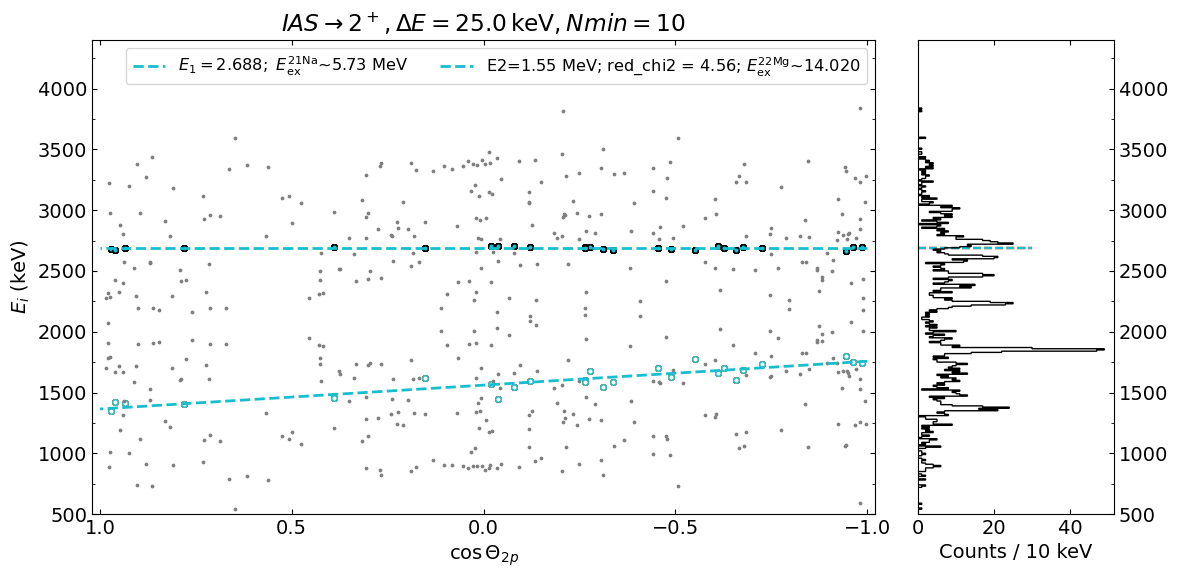

No suitable exctited level was found for 5625


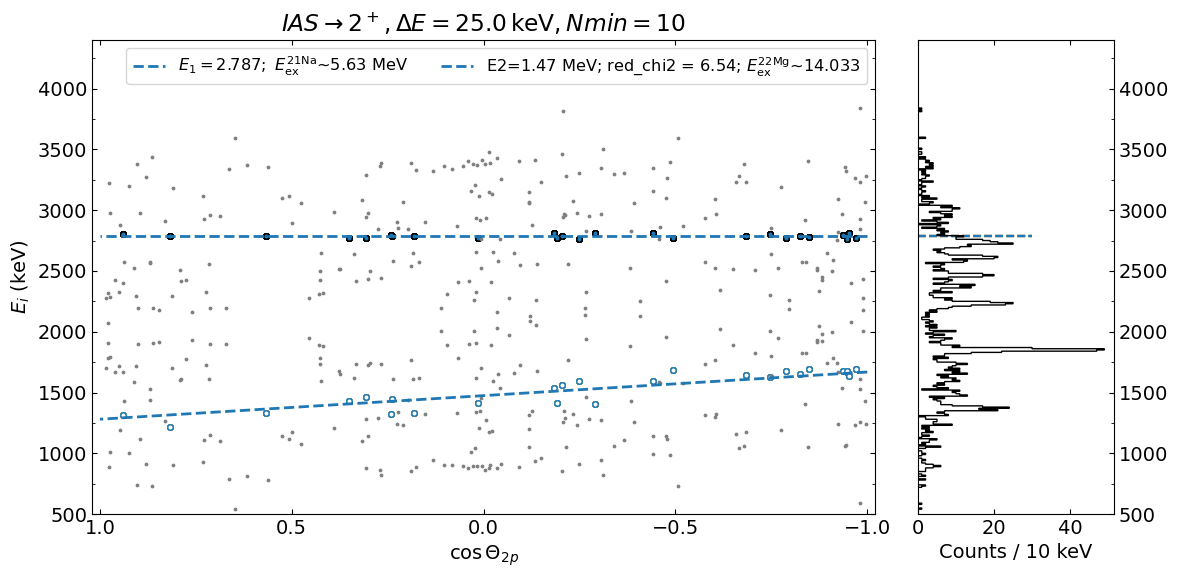

7608 -> ENSDF: [7609.]


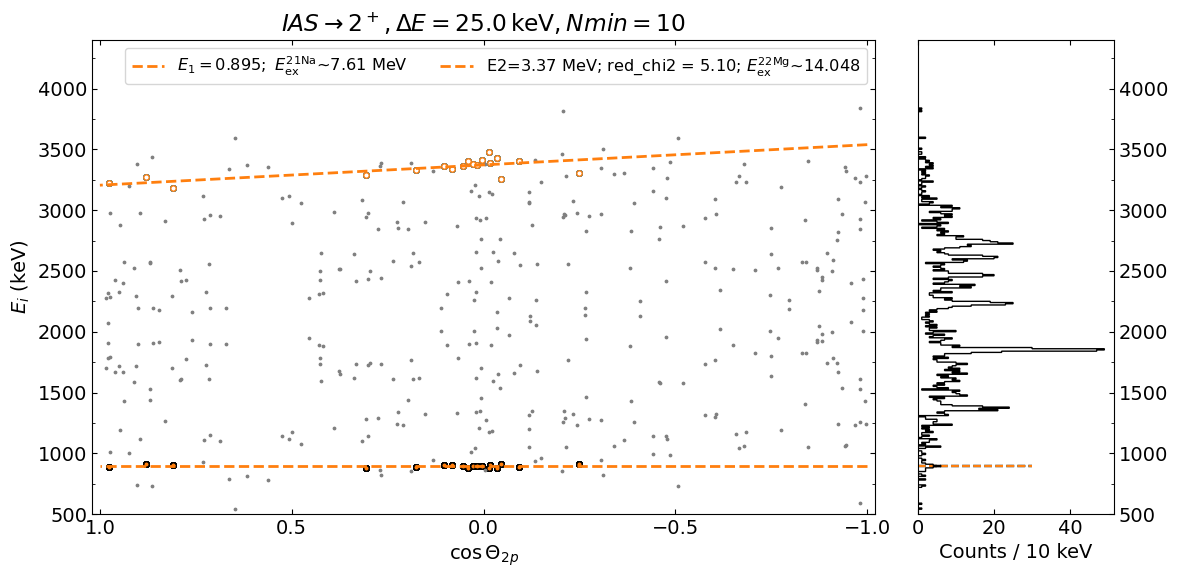

5907 -> ENSDF: [5884.]


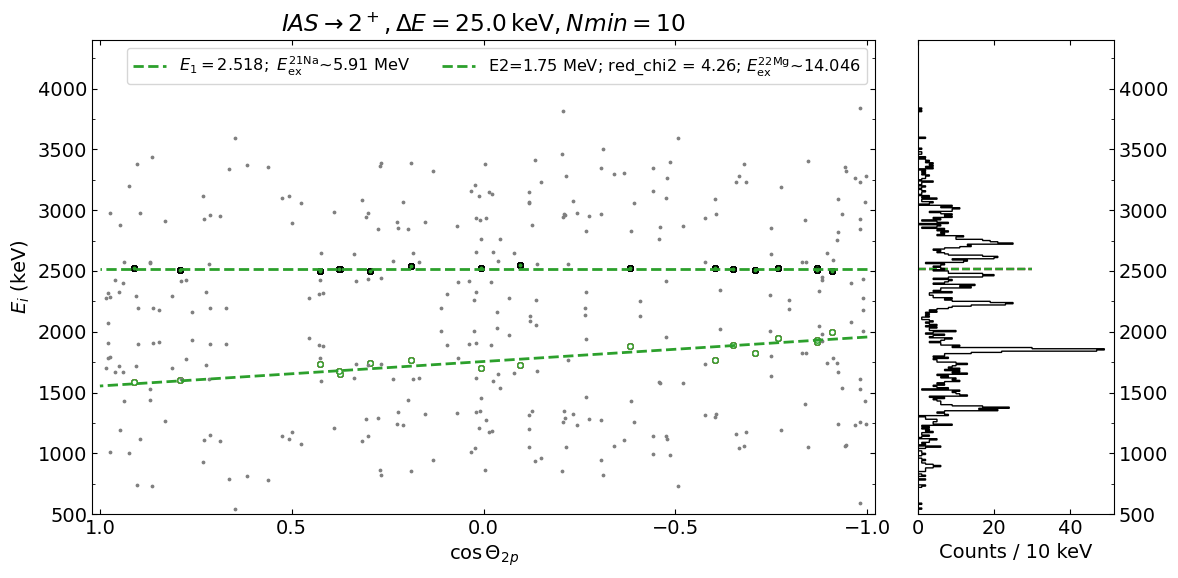

5445 -> ENSDF: [5457.]


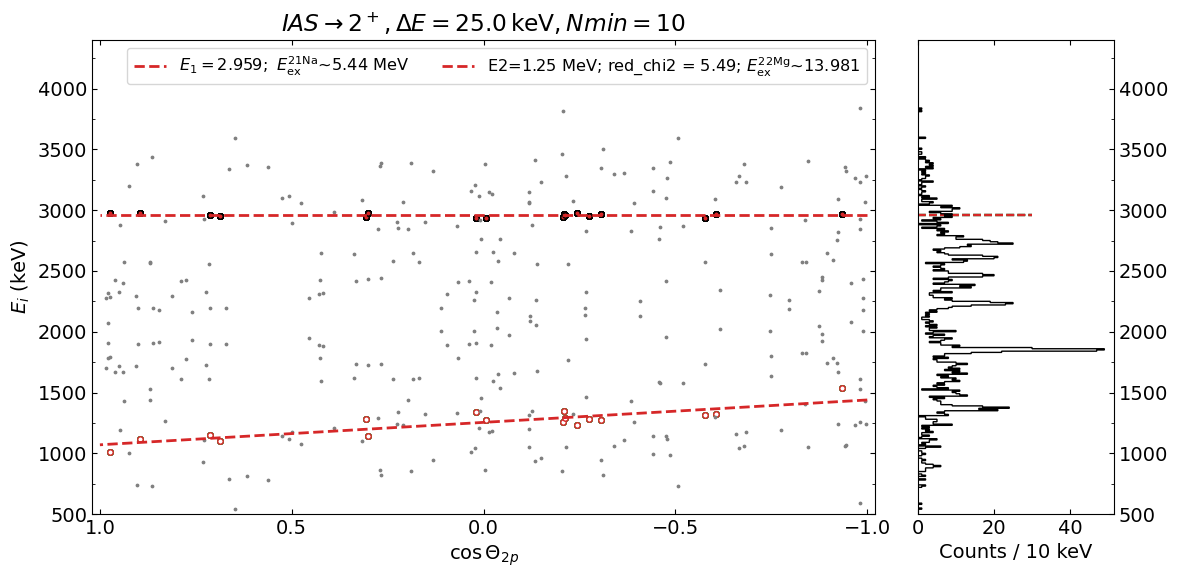

6007 -> ENSDF: [5979.]


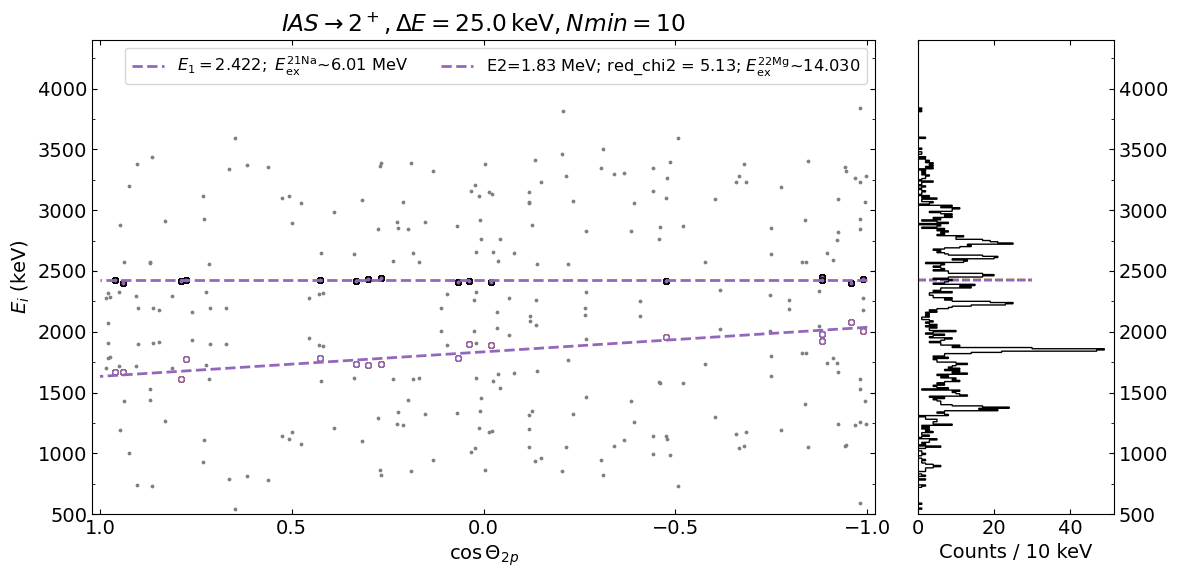

5851 -> ENSDF: [5828.]


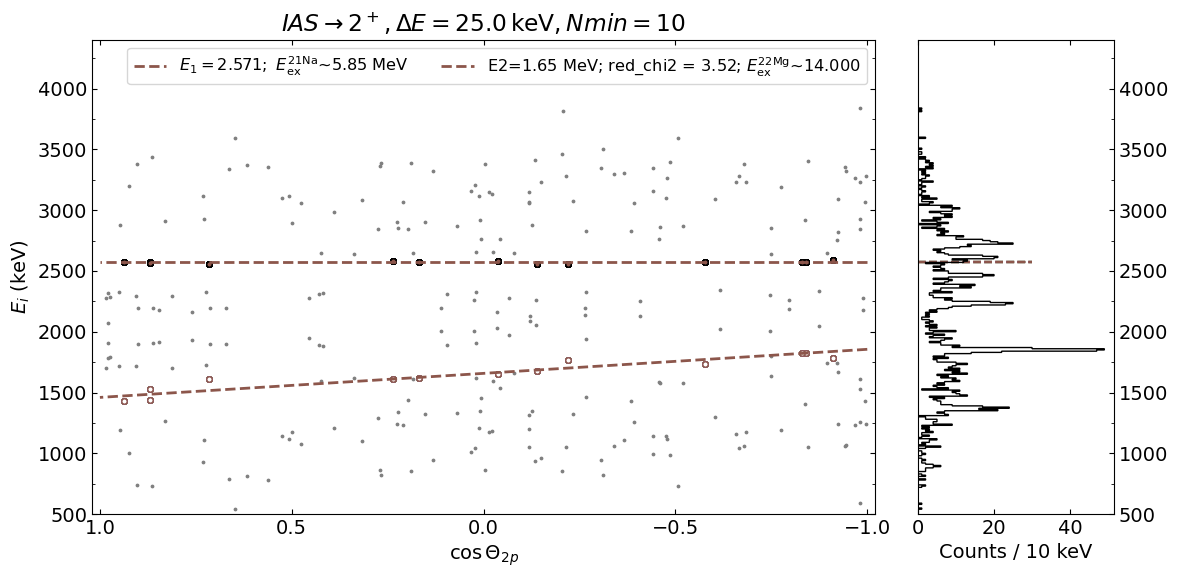

No suitable exctited level was found for 6115


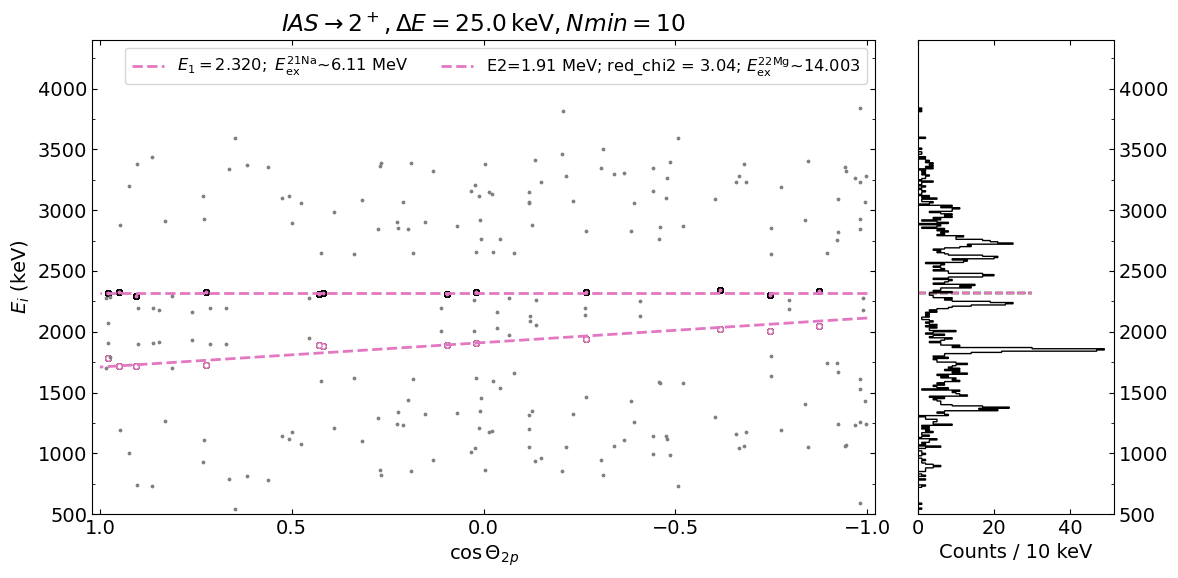

No suitable exctited level was found for 5558


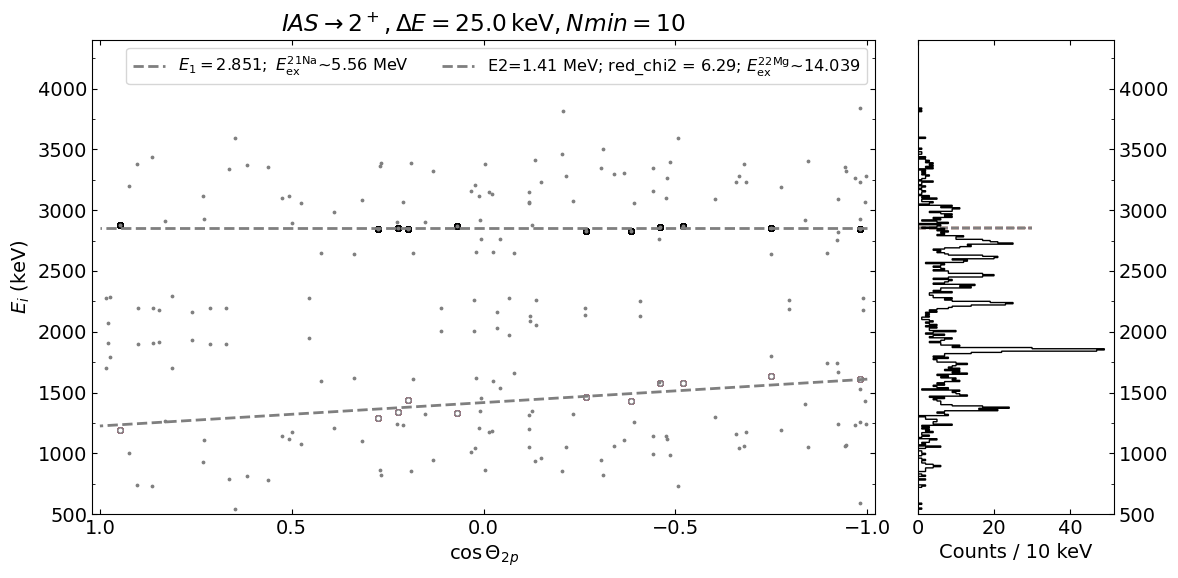

5011 -> ENSDF: [4984. 5020.]
5011 -> Erik: [5020.]


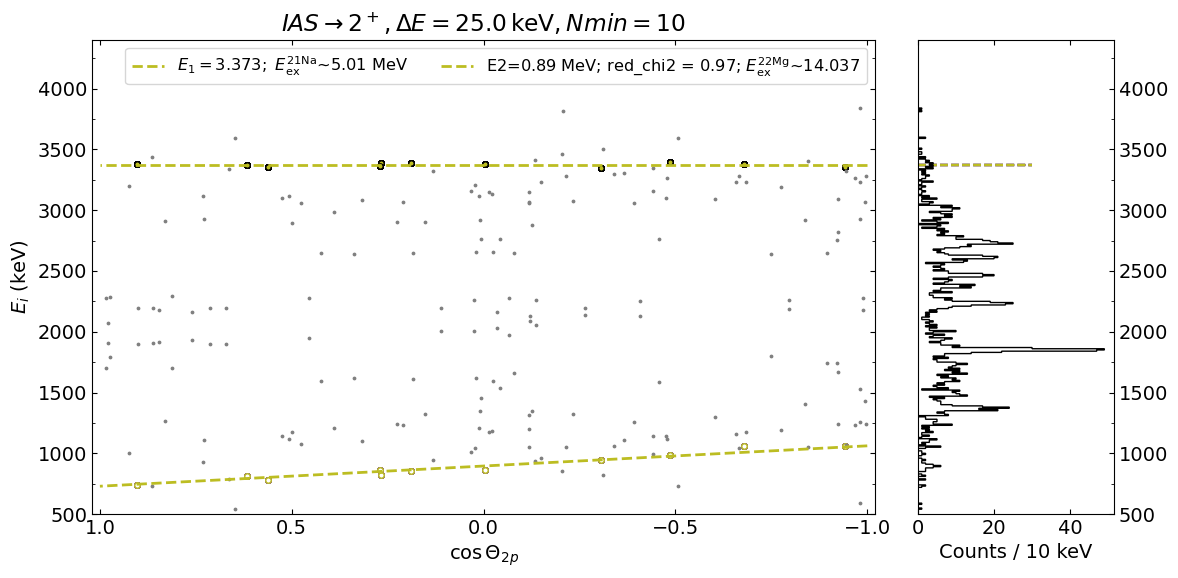

No suitable exctited level was found for 5323


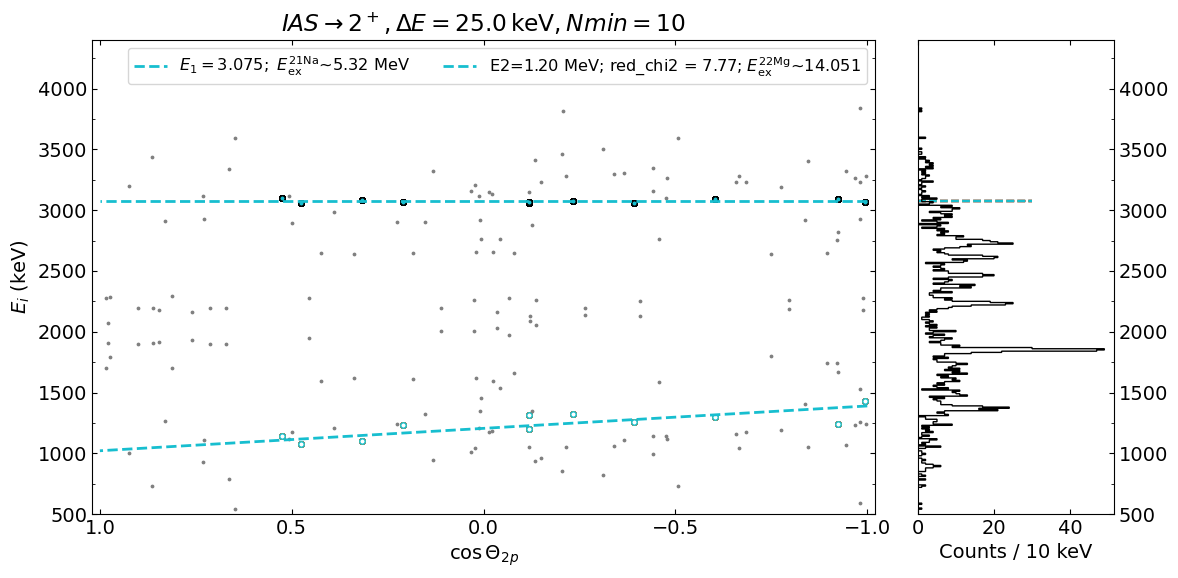

No suitable exctited level was found for 6255


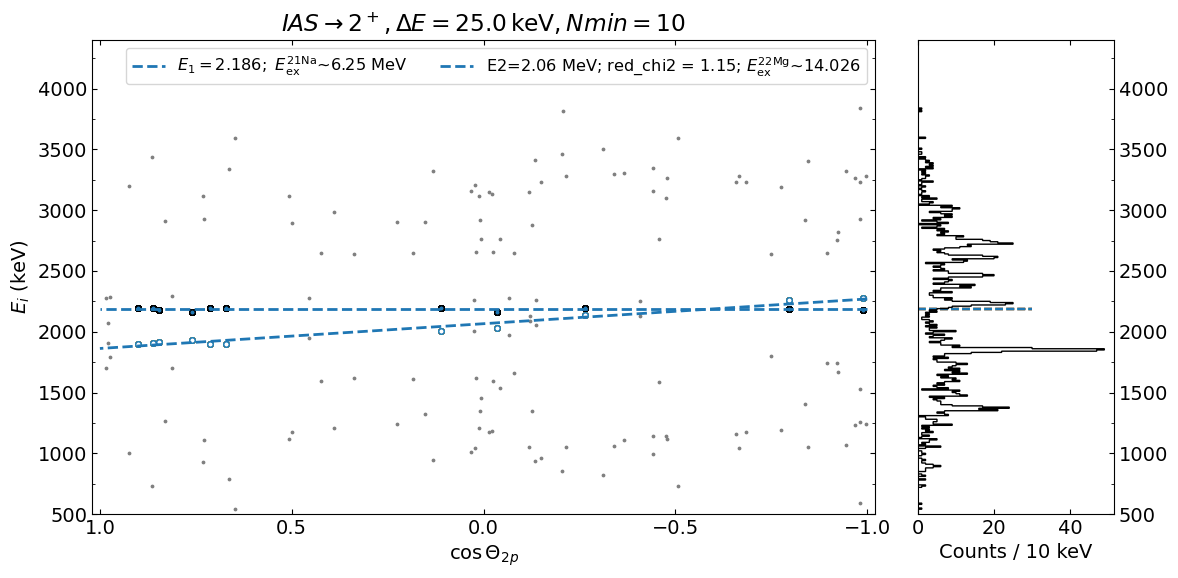

The reduced chi2 values from the fits
[1.758 1.487 2.147 2.424 2.875 1.482 1.977 2.795 2.612 4.562 6.539 5.103
 4.262 5.487 5.126 3.522 3.04  6.287 0.971 7.769 1.153]

Peaks identified by previous studies of 21Na(found values)
[6606. 5683. 6212. 7108. 5809. 5957. 5388. 6978. 6060. 7608. 5907. 5445.
 6007. 5851. 5011.]

Peaks found in Ensdf / Erik ?
[(False, False), (False, False), (False, True), (False, False), (True, False), (True, True), (True, True), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, True)]

Peaks not found to match any previously found levels in 21Na
[6606. 5683. 7108. 5729. 5625. 6115. 5558. 5323. 6255.]

E1 energies:
[1851. 2732. 2227. 1372. 2612. 2470. 3013. 1496. 2372. 2688. 2787.  895.
 2518. 2959. 2422. 2571. 2320. 2851. 3373. 3075. 2186.]
E2 energies:
[2410. 1531. 2030. 2879. 1646. 1788. 1234. 2771. 1880. 1555. 1468. 3370.
 1749. 1248. 1829. 1652. 1906. 1411.  888. 1198. 2061.]
Excited state energi

In [15]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################

assumedEs = np.array([6.600, 5.680, 7.100])*1e3

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 25.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands2, e2bands2, cos1bands2, cos2bands2 = [], [], [], []
Ex2, E1s,E2s = [],[],[]
assigned_counts2 = []

# ---- Q2p gate ----
m   = 4400
lim = (4350,4580)
title = fr"$IAS \rightarrow 2^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
tot_counts = len(cos_th)

N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = 14050  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))
    diff_assumed = (assumedEs- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)
    match_assumed_exists = np.any(np.abs(diff_assumed) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    match_ass= np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists or match_assumed_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts2.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        if not match_assumed_exists:
            assigned_counts2.append(0)


    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands2.append(E1_band)
    e2bands2.append(E2_band)
    cos1bands2.append(cos1_band)
    cos2bands2.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,30,color, ls='--')
        #unused_cos2 = cos_th[event_band_idx == -1]
        #unused_e12 = e1[event_band_idx == -1]
        #unused_e22 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)
    unused_cos2 = cos_th[mask_unassigned]
    unused_e12 = e1[mask_unassigned]
    unused_e22 = e2[mask_unassigned]
    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit+1634)/1e3:.3f}")

    Ex2.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)
    
    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(500,m)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    ########## ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False

    ##########
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))



856 696
Found excited state energies in 21Na:  [6.61 5.68 6.21 7.11 5.81 5.96 5.39 6.98 6.06 7.61 5.91 5.44 6.01 5.85
 5.01]
Percentage of events that was used to assign levels:  81.31 %


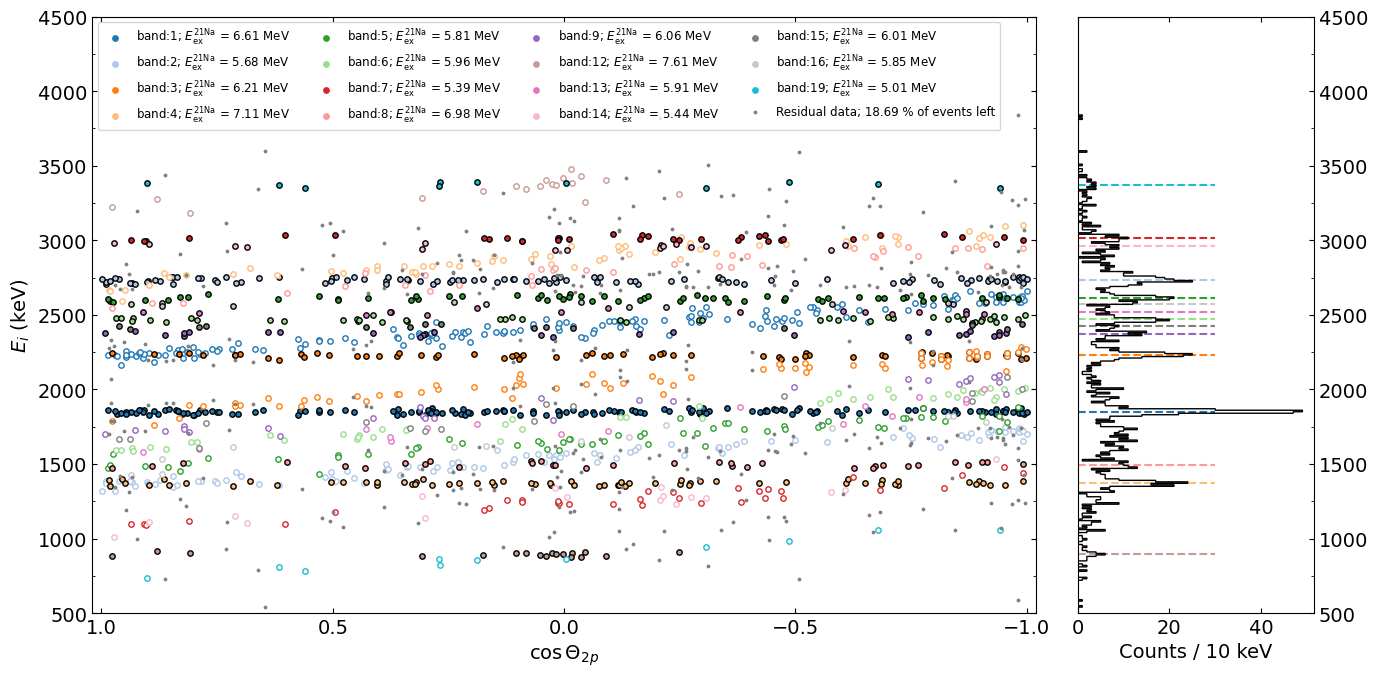

KS statistic = 0.0995, p-value = 0.0946


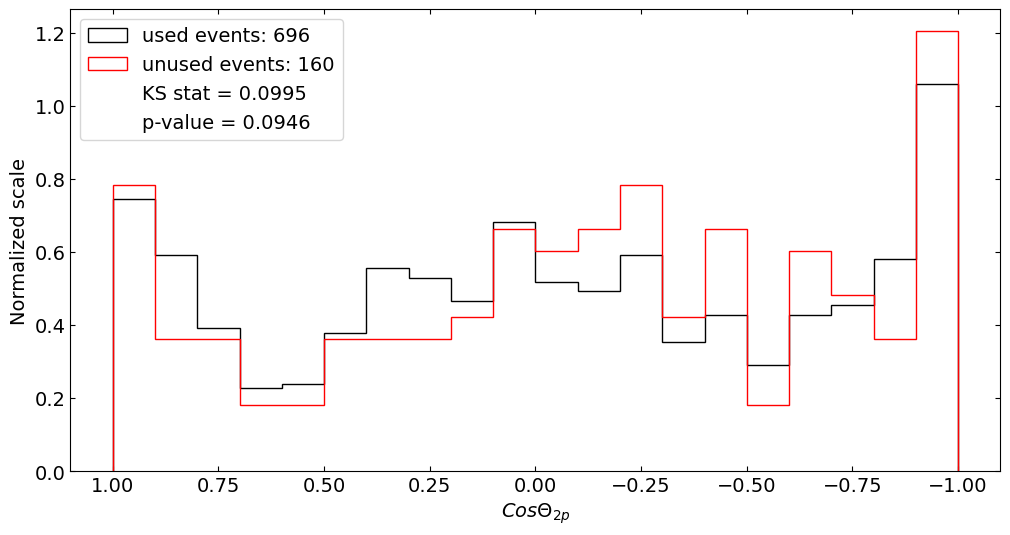

In [19]:
##we assume that 6.6, 5.68, 7.1 exists
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), sharey=True, gridspec_kw={'width_ratios':[4,1]})
plt.rcParams.update({'font.size': 14})

colors = plt.cm.tab20.colors
print(tot_counts, np.sum(assigned_counts2))
# start as empty arrays
non_matched_cos = np.array([])
non_matched_e1  = np.array([])
non_matched_e2  = np.array([])
goodpeaks = np.array([])
ls = np.sum([len(c) for c in cos1bands2])
for b_idx, (cos1, e1b, cos2, e2b, ac,ex) in enumerate(zip(cos1bands2, e1bands2, cos2bands2, e2bands2, assigned_counts2,Ex2)):
    color = colors[b_idx % len(colors)]
    if ac > 0:
        ax1.scatter(cos1, e1b, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2, e2b, s=15, facecolors='white', edgecolors=color)
        ax1.scatter(-1000,-1000, s=15, facecolors=color, label=rf"band:{b_idx+1}; $E_{{\mathrm{{ex}}}}^{{21\mathrm{{Na}}}}$ = {ex/1e3:.2f} MeV")
        ax2.hlines(np.mean(e1b), 0, 30, color=color, ls='--')
        goodpeaks = np.append(goodpeaks,ex)
    elif ac==0:
        # directly extend arrays
        non_matched_cos = np.append(non_matched_cos, cos2)
        non_matched_e1  = np.append(non_matched_e1,  e1b)
        non_matched_e2  = np.append(non_matched_e2,  e2b)

print(f"Found excited state energies in 21Na: ",np.round(goodpeaks/1e3,2))
print(f"Percentage of events that was used to assign levels: ", np.round(np.sum(assigned_counts2)/tot_counts*100, 2), "%")

# now merge with the "unused" ones
unused_cos_ext = np.concatenate((unused_cos2, non_matched_cos))
unused_e1_ext  = np.concatenate((unused_e12,  non_matched_e1))
unused_e2_ext  = np.concatenate((unused_e22,  non_matched_e2))

# plot all unused/non-matched in gray
ax1.scatter(unused_cos_ext, unused_e1_ext, color='gray', s=3, label=f"Residual data; {100-np.round(np.sum(assigned_counts2)/tot_counts*100, 2):.2f} % of events left")
ax1.scatter(unused_cos_ext, unused_e2_ext, color='gray', s=3)

ax1.set_xlabel(r"$\cos\Theta_{2p}$")
ax1.set_ylabel(r"$E_i$ (keV)")
ax1.set_yticks(np.arange(0, 6000, 250), minor=True)
ax1.set_xticks(np.arange(1,-1.5,-0.5))
ax1.set_xlim(1.02,-1.02)
plt.rcParams.update({'font.size': 8.5})
ax1.legend(ncol=4)
plt.rcParams.update({'font.size': 14})

mask = (Q2p>4350) & (Q2p<4580)
bins = np.arange(0, 7000+10, 10)
h1, _ = np.histogram(E1[mask], bins=bins)
h2, _ = np.histogram(E2[mask], bins=bins)
ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step', orientation='horizontal', color='k')
ax2.set_xlabel('Counts / 10 keV')
ax2.yaxis.set_ticks_position('right')
ax2.set_yticks(np.arange(0, 4400, 250), minor=True)
ax1.set_ylim(500, 4500)

fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
plt.tight_layout()
plt.savefig("all2p2.pdf")
plt.show()
#ks_2samp
#plt.hist(unused_cos_ext)

from scipy.stats import ks_2samp


plt.figure(figsize=(12,6))
bi = np.arange(-1,1+0.1,0.1)
h4, _ = np.histogram(unused_cos_ext, bins=bi)
w1 = 0
w2 = 0
unused = np.array(unused_cos_ext)
used = np.concatenate(cos1bands2 + cos2bands2)

for c1,c2 in zip(cos1bands2,cos2bands2):
    h5, _ = np.histogram(c1, bins=bi)
    h6, _ = np.histogram(c2, bins=bi)
    w1+=h5
    w2+=h6
plt.hist(bi[:-1], bins=bi, weights=w1+w2, histtype='step', color='k', density=True, label=f"used events: {np.sum(assigned_counts2)}")
plt.hist(bi[:-1], bins=bi, weights=h4, histtype='step', color='r', density=True, label=f"unused events: {tot_counts-np.sum(assigned_counts2)}")
plt.xticks(np.arange(1.5,-1.5,-0.25))
plt.xlim(1.1,-1.1)
plt.legend(loc='upper left')
plt.xlabel(r"$Cos\Theta _{2p}$")
plt.ylabel("Normalized scale")



ksstatistic, pvalue = ks_2samp(used, unused)

print(f"KS statistic = {ksstatistic:.4f}, p-value = {pvalue:.4g}")
plt.plot([], [], ' ', label=f"KS stat = {ksstatistic:.4f}")
plt.plot([], [], ' ', label=f"p-value = {pvalue:.4g}")


plt.legend(loc='upper left', fontsize=14)
plt.savefig("kstest.pdf")



Found 21Na levels from IAS->0+:  [3550. 3662. 3870. 4297. 5762. 5811. 5858. 6975.]
Found 21Na levels from IAS->2+:  [5011. 5388. 5445. 5809. 5851. 5907. 5957. 6007. 6060. 6212. 6978. 7108.
 7608.]


21Na levels that both pass through (IAS->0+, IAS->2+):  [(5811, 5809), (5858, 5851), (6975, 6978)]
	5810 and 5855 peaks are most likely a double peak where the bias from removing 5810 events makes it so that the 5855 events that remain are pushed to a higher energy.
	This is most like just the double peak at 5815 and 5828 that is known. This corresponds to 7/2- and 3/2- which makes sense since 3/2- is supressed compared to 7/2-




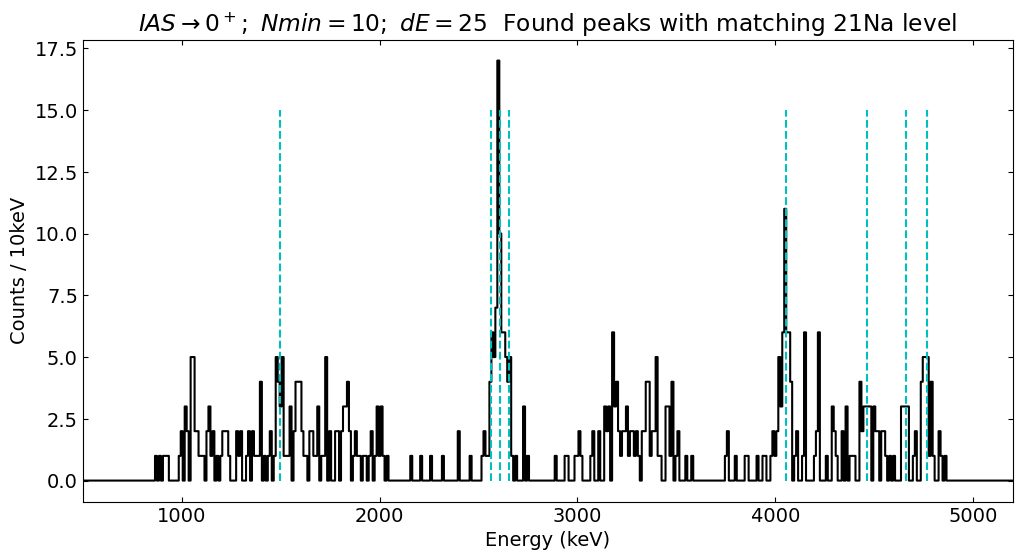

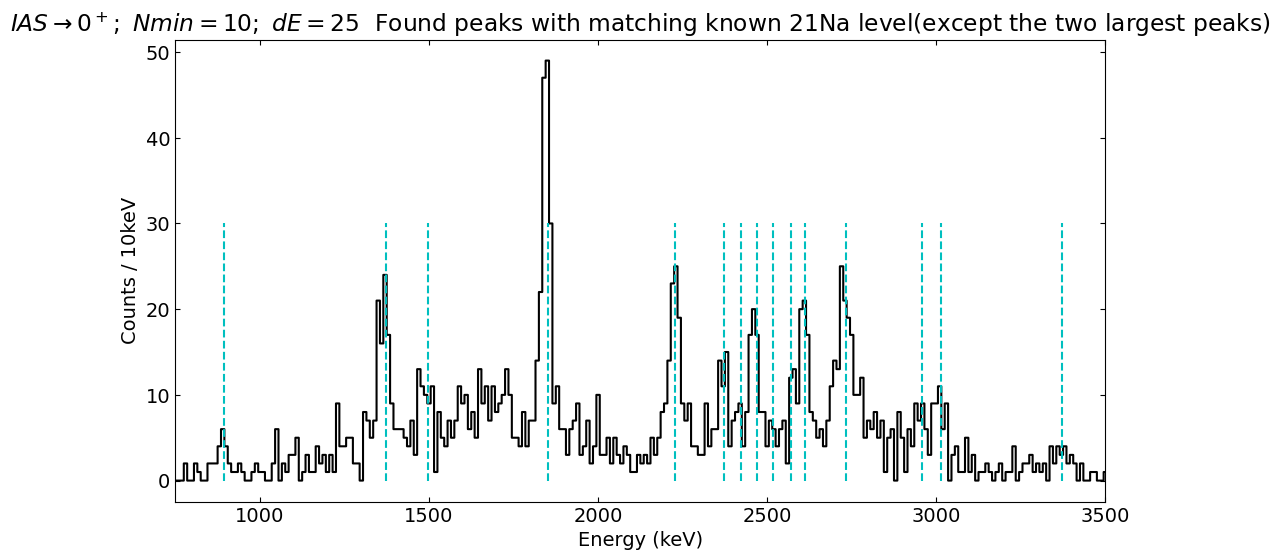

In [17]:
plt.figure(figsize=(12,6))
lims = (6000,6230)
mask = (Q2p >= lims[0]) & (Q2p <= lims[1])
h1, _ = np.histogram(np.array(E1)[mask], bins=bins)
h2, _ = np.histogram(np.array(E2)[mask], bins=bins)
plt.step(bins[:-1], h1+h2, where='mid', color='k')

E1s0 = [2609. ,4054. ,4767. ,2656. ,1499. ,2565. ,4462., 4660.]
ex0 = [5811., 4297., 3550., 5762., 6975., 5858. ,3870.,3662.]
E2s0 = [3207., 1748., 1035. ,3201. ,4321. ,3230., 1346. ,1171.]

for e in E1s0:
    plt.vlines(e, 0,15, ls='--', color='c')
plt.xlim(500,5200)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts / 10keV")
plt.title(r"$IAS\rightarrow 0^+; \ Nmin=10; \ dE=25$  Found peaks with matching 21Na level")
#print("Found 21Na levels from IAS->0+: ",np.sort(ex0))
################################################################################################
plt.figure(figsize=(12,6))
lims = (4350,4580)
mask = (Q2p >= lims[0]) & (Q2p <= lims[1])
h1, _ = np.histogram(np.array(E1)[mask], bins=bins)
h2, _ = np.histogram(np.array(E2)[mask], bins=bins)
plt.step(bins[:-1], h1+h2, where='mid', color='k')
E2s2 = [2410., 1531., 2030.,2879., 1646., 1788., 1234., 2771., 1880.,3370.,1749. ,1248., 1829. ,1652., 888.]
E1s2 = [1851., 2732., 2227.,1372,2612. ,2470., 3013. ,1496. ,2372., 2422., 2571.,3373., 895.,2518. ,2959.]
ex2 = [6212. ,5809. ,5957., 7108.,5388., 6978., 6060., 7608., 5907., 5445., 6007. ,5851. ,5011.]

for e in E1s2:
    plt.vlines(e, 0,30, ls='--', color='c')
plt.xlim(750,3500)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts / 10keV")
plt.title(r"$IAS\rightarrow 0^+; \ Nmin=10; \ dE=25$  Found peaks with matching known 21Na level(except the two largest peaks)")
print()
print("="*120)
print()
print("Found 21Na levels from IAS->0+: ",np.sort(ex0))
print("Found 21Na levels from IAS->2+: ",np.sort(ex2))
print()
print("="*120)
print()
print("21Na levels that both pass through (IAS->0+, IAS->2+): ", [(5811, 5809), ((5858,5851)), (6975,6978)])
print("\t"+ "5810 and 5855 peaks are most likely a double peak where the bias from removing 5810 events makes it so that the 5855 events that remain are pushed to a higher energy."+"\n"+"\t"+
    "This is most like just the double peak at 5815 and 5828 that is known. This corresponds to 7/2- and 3/2- which makes sense since 3/2- is supressed compared to 7/2-")
print()
print("="*120)

print()

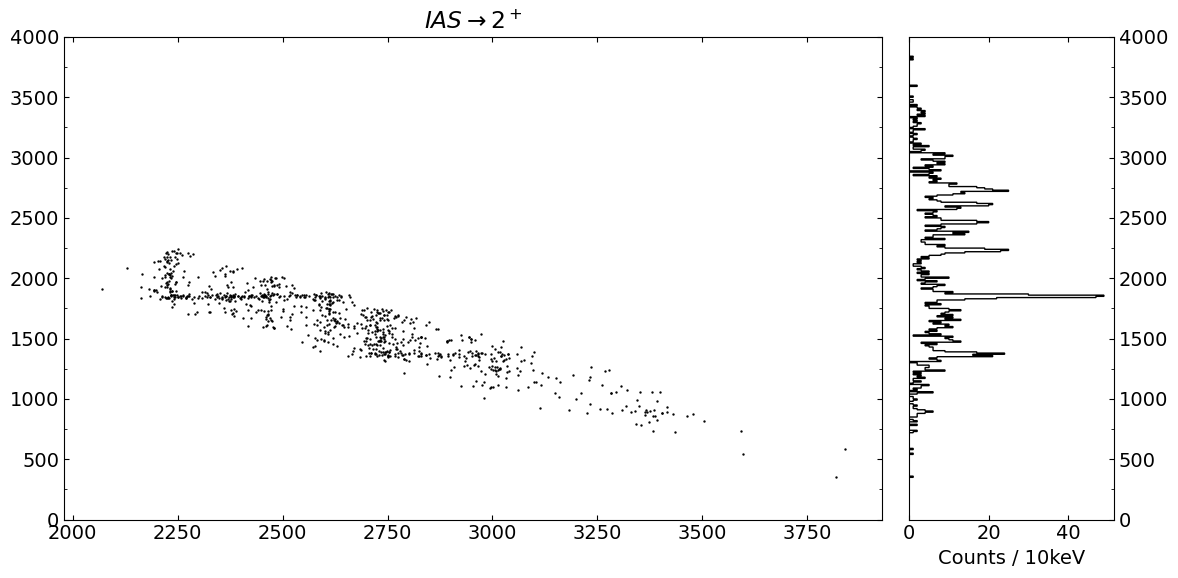

(750.0, 2500.0)

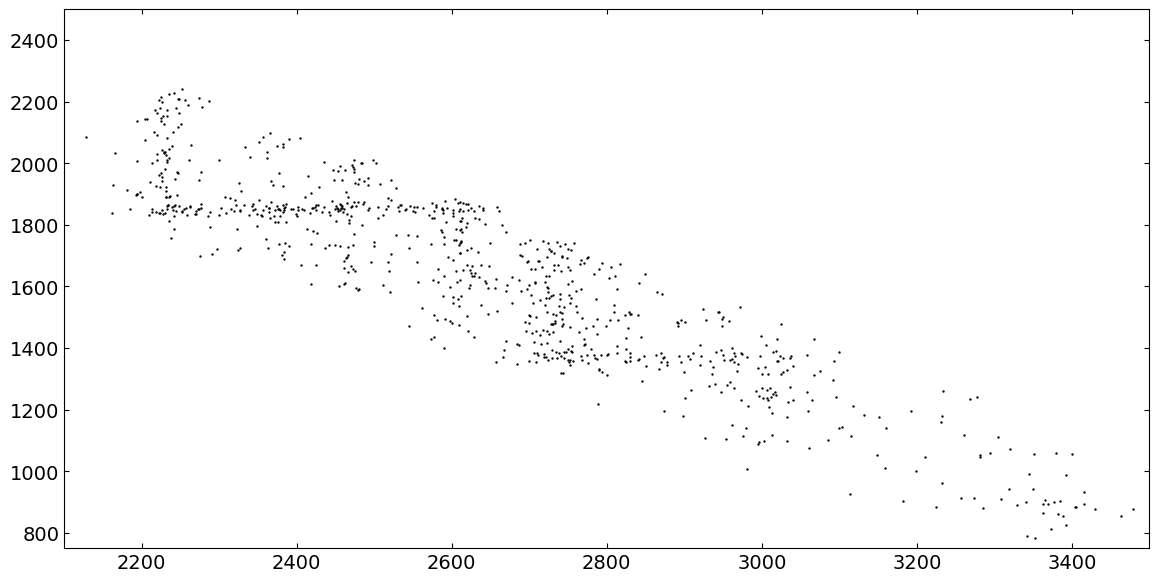

In [18]:
ms = [4000]#, 5200, 3200, 2500]
lims = [(4350,4580)]#, (6000,6230), (3360,3590), (2400,2600)]
ranges1 = [(1330,1400), (1810,1880), (2210,2260), (2440,2490), (2580,2630), (2690,2760)]
ranges2= [(2530,2670), (4020,4100)]
ranges3 = [(1960,2050), (2050,2140)]
ranges4 = [(950,1050)]


trans = [r"$IAS\rightarrow{2}^+$"]#,r"$IAS\rightarrow{0}^+$",r"$?\rightarrow?$", r"$?\rightarrow?$"]
for l, m,t in zip(lims, ms,trans):
    mask = (Q2p >= l[0]) & (Q2p <= l[1])
    Q_mean = (l[0]+l[1])/2
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True, 
        gridspec_kw={'width_ratios':[4,1]}
    )
    
    # Left: scatter plot
    #ax1.scatter(np.cos(theta[mask]), E1[mask], color='k', s=0.5)
    #ax1.scatter(np.cos(theta[mask]), E2[mask], color='k', s=0.5)
    #ax1.set_xlabel(r"$Cos\Theta_{2p}$")
    #ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(f"{t}")
    ax1.set_yticks(np.arange(0,m,250), minor=True)
    ax1.set_ylim(500, m)
    
    # Right: horizontal histogram with 'step' style
    h1, _ = np.histogram(E1[mask], bins=bins)
    h2, _ = np.histogram(E2[mask], bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step', orientation='horizontal', color='k')
    
    ex = [] ## largest vals
    ey = [] ## lowest vals
    for e1,e2 in zip(E1[mask], E2[mask]):
        if e1>e2:
            ex.append(e1)
            ey.append(e2)
        else:
            ex.append(e2)
            ey.append(e1)
    ax1.scatter(ex,ey, color='k', s=0.5)  
    
    #bins2 = np.arange(950,1050+10,10)
    #h3, _ = np.histogram(E1[mask], bins=bins2)
    #h4, _ = np.histogram(E2[mask], bins=bins2)
    #ax2.hist(bins2[:-1], bins=bins2, weights=h3+h4, histtype='step', orientation='horizontal', color='r')

    
    ax2.set_xlabel('Counts / 10keV')
    ax2.yaxis.set_ticks_position('right')  # ticks on right side
    ax2.set_yticks(np.arange(0,m, 250), minor=True)
    
    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()
plt.figure(figsize=(14,7))
plt.scatter(ex,ey, color='k', s=0.5)
plt.xlim(2100,3500)
plt.ylim(750,2500)